# Part 6: Analysis in Neo4j and GDS

This notebook covers:
1. Schema Visualization and Initial Graph Inspection
2. Setting Uniqueness Constraints
3. Estimating and Executing Native Graph Projections
4. Quick Example of Weakly Connected Components (WCC)

## Schema Visualization and Initial Graph Inspection


Many of the commands in this section are best executed in the Neo4j Browser to visualize and interact with the results. 

### 1. Visualize Schema

```CALL db.schema.visualization();```
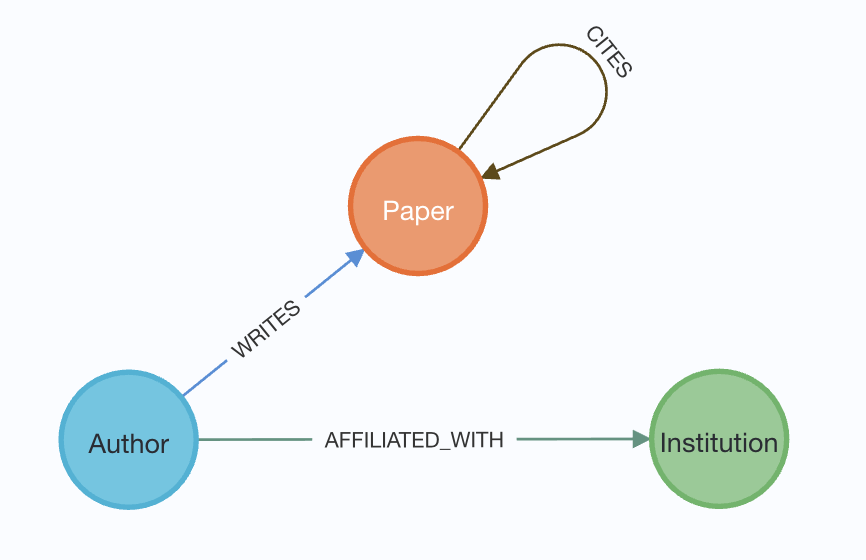


### 2. Node and Relationship counts

There are multiple ways to obtain aggregate counts.  I find `apoc.meta.stats()` to be quick and easy, it does require that you have APOC installed.

These counts should match those on the [OGB MAG240M Page](https://ogb.stanford.edu/kddcup2021/mag240m/).

```CALL apoc.meta.stats() YIELD labels```

```
{
  "Author": 122383112,
  "Paper": 121751666,
  "Institution": 25721
}
```

```CALL apoc.meta.stats() YIELD relTypesCount```

```
{
  "AFFILIATED_WITH": 44592586,
  "CITES": 1297748926,
  "WRITES": 386022720
}
```

### 3. Example Query

Just to visualize a portion of the graph in Cypher for a sanity check. 

```
MATCH (n:Paper)
WITH n LIMIT 30
MATCH (n)-[r]-(m)-[s:AFFILIATED_WITH]->(p)
RETURN *
```

.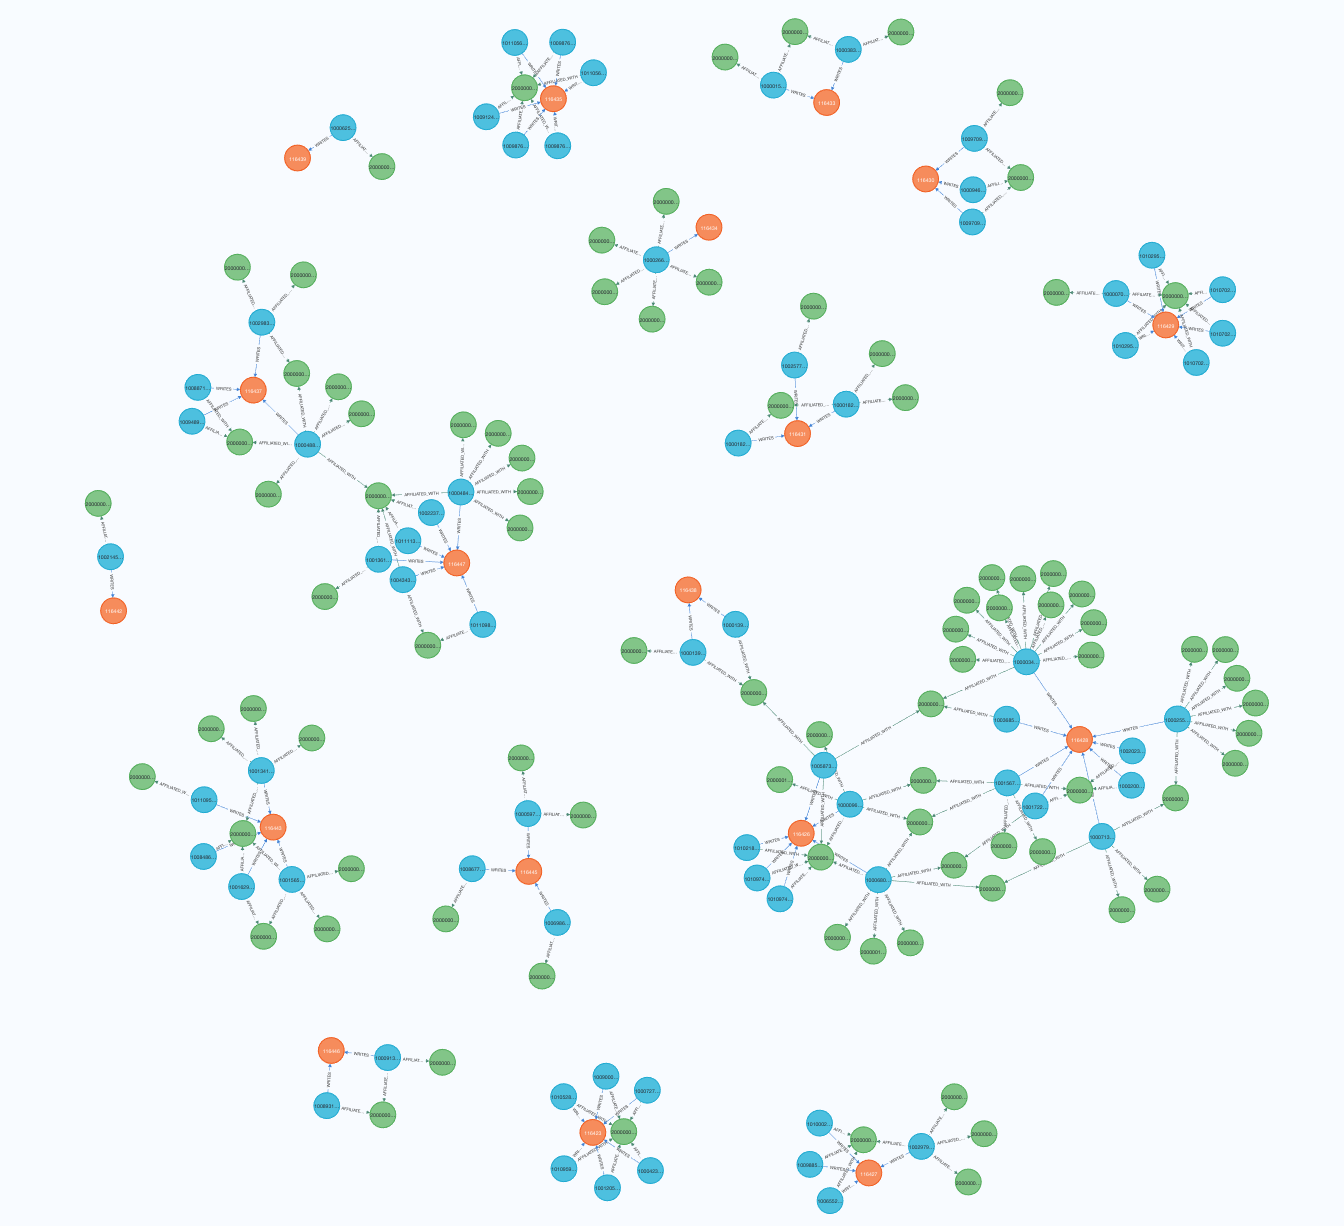

## Connection Setup and Helper Functions

In [1]:
from neo4j import GraphDatabase
HOST = 'neo4j://localhost:7687'
USERNAME = 'neo4j'
DATABASE = 'ogblsc'
PASSWORD = 'neo'

In [2]:
def run(driver, query, params=None):
    with driver.session(database=DATABASE) as session:
        if params is not None:
            return [r for r in session.run(query, params)]
        else:
            return [r for r in session.run(query)]


def clear_graph(driver, graph_name):
    if run(driver, f"CALL gds.graph.exists('{graph_name}') YIELD exists RETURN exists")[0].get("exists"):
        run(driver, f"CALL gds.graph.drop('{graph_name}')")

def clear_all_graphs(driver):
    graphs = run(driver, 'CALL gds.graph.list() YIELD graphName RETURN collect(graphName) as graphs')[0].get('graphs')
    for g in graphs:
        run(driver, f"CALL gds.graph.drop('{g}')")

In [3]:
driver = GraphDatabase.driver(HOST, auth=(USERNAME, PASSWORD))

## Setting Uniqueness Constraints

It is a good practice to set uniqueness constraints on the ogb index for each node label.  This will not affect performance for GDS operations used in this project.  However, such constraints will significantly improve performance for `MATCH` and `MERGE` type cypher queries which may be relevant in extended analysis. 

In [4]:
%%time
# Was set previously so finished quickly
run(driver, 'CREATE CONSTRAINT consPaperId IF NOT EXISTS ON (n:Paper) ASSERT n.ogbIndex IS UNIQUE;')

CPU times: user 4.23 ms, sys: 3.25 ms, total: 7.48 ms
Wall time: 62.9 ms


[]

In [5]:
%%time
run(driver, 'CREATE CONSTRAINT consAuthorId IF NOT EXISTS ON (n:Author) ASSERT n.ogbIndex IS UNIQUE;')

CPU times: user 8.57 ms, sys: 1.7 ms, total: 10.3 ms
Wall time: 1min 58s


[]

In [6]:
%%time
run(driver, 'CREATE CONSTRAINT consInstitutionId IF NOT EXISTS ON (n:Institution) ASSERT n.ogbIndex IS UNIQUE;')

CPU times: user 2.23 ms, sys: 473 µs, total: 2.7 ms
Wall time: 267 ms


[]

## Estimating and Executing Native Graph Projections

In [8]:
# memory estimation for native graph projection of all graph elements with no properties
run(driver,'''
    CALL gds.graph.create.estimate('*','*',{readConcurrency: 60}) 
    YIELD nodeCount, relationshipCount, requiredMemory, bytesMin, bytesMax
''')

[<Record nodeCount=244160499 relationshipCount=1728364232 requiredMemory='[8617 MiB ... 13508 MiB]' bytesMin=9036239896 bytesMax=14164271448>]

In [10]:
# Execute native graph projection of all graph elements with no properties
run(driver,'''
    CALL gds.graph.create('proj', '*', '*', {readConcurrency: 60}) 
    YIELD nodeCount, relationshipCount, createMillis
''')

[<Record nodeCount=244160499 relationshipCount=1728364232 createMillis=43622>]

## Quick Example of Weakly Connected Components (WCC)

In [12]:
result = run(driver, '''
    CALL gds.wcc.mutate('proj', {
          concurrency: 60,
          mutateProperty: 'componentId'
    })
''')[0]

In [16]:
# time to run WCC
for i in ['computeMillis', 'mutateMillis', 'postProcessingMillis']:
    print(f' {i}: {result.get(i)}')

 computeMillis: 14352
 mutateMillis: 0
 postProcessingMillis: 3746


In [18]:
# component count and node properties written 
print(f'componentCount: {result.get("componentCount")}')
print(f'nodePropertiesWritten: {result.get("nodePropertiesWritten")}')

componentCount: 23130564
nodePropertiesWritten: 244160499


In [19]:
# component distribution
result.get('componentDistribution')

{'p99': 8,
 'min': 2,
 'max': 183601151,
 'mean': 10.555750045697113,
 'p90': 4,
 'p50': 2,
 'p999': 23,
 'p95': 5,
 'p75': 3}

In [21]:
#remove graph projection to clean up
clear_graph(driver, 'proj')